<a href="https://colab.research.google.com/github/loaiwalid07/Portfolio/blob/main/Classify_flowers_with_transfer_learning_%26_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using CNN and Transfer Learning



# Imports


Some normal imports we've seen before. The new one is importing tensorflow_hub which this Colab will make heavy use of.

In [1]:
import tensorflow as tf

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import shutil
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# TODO: Download the Flowers Dataset using TensorFlow Datasets

In [5]:
splits = ['train[:70%]','train[70%:]']

(training_set, validation_set), dataset_info = tfds.load('tf_flowers' ,
                                                         split = splits,
                                                         with_info=True,
                                                         as_supervised=True,
                                                         ) 

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


____

In [85]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

Also, the dataset we have downloaded has following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

As you can see there are no folders containing training and validation data. Therefore, we will have to create our own training and validation set. Let's write some code that will do this.


The code below creates a `train` and a `val` folder each containing 5 folders (one for each type of flower). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:


<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Since we don't delete the original folders, they will still be in our `flower_photos` directory, but they will be empty. The code below also prints the total number of flower images we have for each type of flower. 

In [82]:
total_train = 0
total_val = 0
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [88]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]
  total_train += len(train)
  total_val += len(val)

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [89]:
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training images: 2935
Total validation images: 735


For convenience, let us set up the path for the training and validation sets

In [90]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Print Information about the Flowers Dataset 

In [16]:
num_classes = dataset_info.features['label'].num_classes 
num_training_examples = len(training_set)
num_validation_examples = len(validation_set)

In [17]:
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



The images in the Flowers dataset are not all the same size.

In [7]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and Create Batches


In [91]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

num_exp = dataset_info.splits['train'].num_examples

train_batches = training_set.cache().shuffle(num_exp//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

### Data Augmentation

rescales the images by 255 and that applies:
- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shift of 0.15


In [94]:
image_gen_train = ImageDataGenerator(rescale =1./255,
                                     rotation_range = 45,
                                     zoom_range = 0.5,
                                     horizontal_flip=True,
                                     width_shift_range = 0.15,
                                     height_shift_range = 0.15)


train_data_gen = image_gen_train.flow_from_directory(directory = train_dir,
                                                 target_size = (IMAGE_RES,IMAGE_RES),
                                                 shuffle = True,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'sparse')

Found 2935 images belonging to 5 classes.


In [96]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


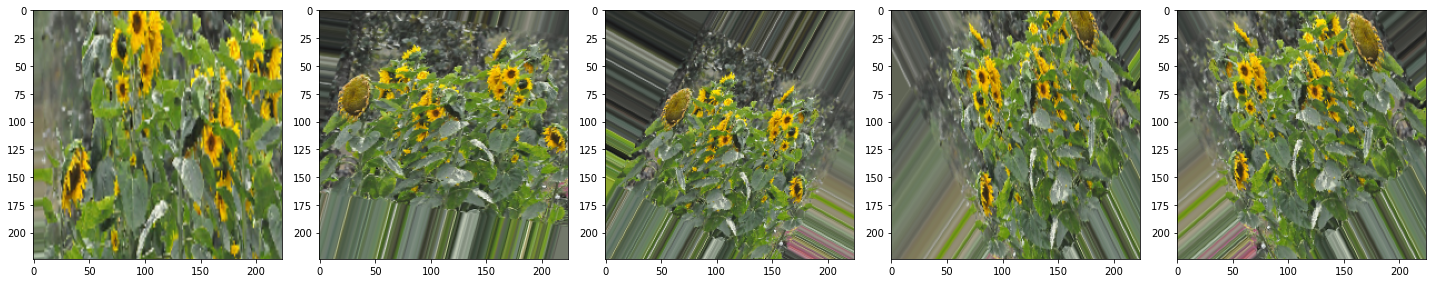

In [97]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create a Data Generator for the Validation Set


In [99]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen =image_gen_val.flow_from_directory(directory = val_dir,
                                                target_size = (IMAGE_RES,IMAGE_RES),
                                                batch_size = BATCH_SIZE,
                                                class_mode="sparse") 

Found 735 images belonging to 5 classes.


# Create the CNN

 

In [101]:
model_1 = tf.keras.models.Sequential([
                             tf.keras.layers.Conv2D(16,3,padding='same',activation='relu',input_shape = (IMAGE_RES,IMAGE_RES,3) ),
                             tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
                             tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
                             tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                             
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512,activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(5)]) 

# Compile the Model


In [102]:
# Compile the model
model_1.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

In [103]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)      

#  Train the Model


In [ ]:
Epochs = 20

history = model_1.fit_generator(        train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=Epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
                            )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
30/30 [==============================] - 24s 769ms/step - loss: 2.2977 - accuracy: 0.2164 - val_loss: 1.6094 - val_accuracy: 0.2177
Epoch 2/20
30/30 [==============================] - 23s 751ms/step - loss: 1.6094 - accuracy: 0.2160 - val_loss: 1.6094 - val_accuracy: 0.2177
Epoch 3/20
30/30 [==============================] - 22s 748ms/step - loss: 1.6134 - accuracy: 0.2208 - val_loss: 1.6094 - val_accuracy: 0.2449
Epoch 4/20
30/30 [==============================] - 22s 750ms/step - loss: 1.6094 - accuracy: 0.2446 - val_loss: 1.6094 - val_accuracy: 0.2449
Epoch 5/20
30/30 [==============================] - 22s 749ms/step - loss: 1.6094 - accuracy: 0.2443 - val_loss: 1.6094 - val_accuracy: 0.2449
Epoch 6/20
30/30 [==============================] - 22s 748ms/step - loss: 1.6094 - accuracy: 0.2446 - val_loss: 1.6094 - val_accuracy: 0.2449
Epoch 7/20
30/30 [==============================] - 22s 749ms/step - loss: 1.6094 - accuracy: 0.2446 - val_loss: 1.6094 - val_accuracy: 0.2449

# Plot Training and Validation Graphs.



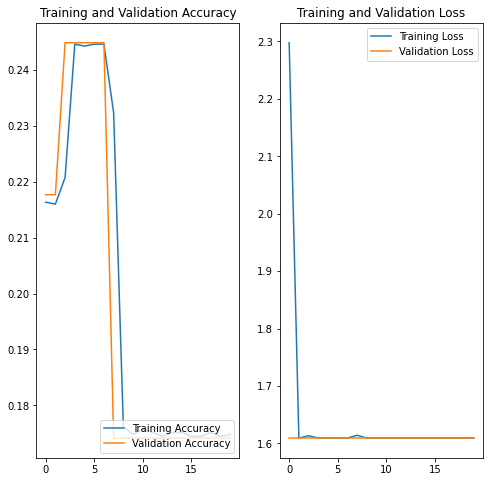

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Do Simple Transfer Learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning. Remember, in transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

### Create a Feature Extractor


In [21]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

feature_extractor = hub.KerasLayer(URL,input_shape = (IMAGE_RES,IMAGE_RES,3)) 

### Freeze the Pre-Trained Model


In [22]:
feature_extractor.trainable = False

### Attach a classification head


In [104]:
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dense(5)])


###  Train the model


In [106]:
model.compile(optimizer='adam',
              loss =tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = 'accuracy')

EPOCHS = 6

history_2 = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data =validation_batches)

Epoch 1/6
81/81 [==============================] - 7s 61ms/step - loss: 0.3804 - accuracy: 0.8708 - val_loss: 0.3341 - val_accuracy: 0.8892
Epoch 2/6
81/81 [==============================] - 4s 53ms/step - loss: 0.2807 - accuracy: 0.9101 - val_loss: 0.3297 - val_accuracy: 0.8738
Epoch 3/6
81/81 [==============================] - 4s 52ms/step - loss: 0.2344 - accuracy: 0.9264 - val_loss: 0.2908 - val_accuracy: 0.8965
Epoch 4/6
81/81 [==============================] - 4s 53ms/step - loss: 0.1996 - accuracy: 0.9424 - val_loss: 0.2849 - val_accuracy: 0.9046
Epoch 5/6
81/81 [==============================] - 5s 65ms/step - loss: 0.1728 - accuracy: 0.9548 - val_loss: 0.2773 - val_accuracy: 0.8983
Epoch 6/6
81/81 [==============================] - 5s 57ms/step - loss: 0.1520 - accuracy: 0.9607 - val_loss: 0.2864 - val_accuracy: 0.9001


You can see we get ~88% validation accuracy with only 6 epochs of training, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~76% accuracy with 80 epochs of training. The reason for this difference is that MobileNet v2 was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

#  Plot Training and Validation Graphs


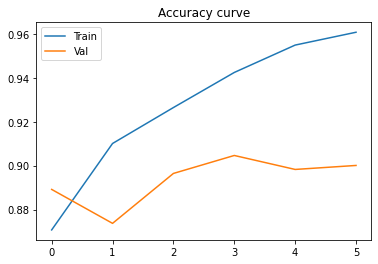

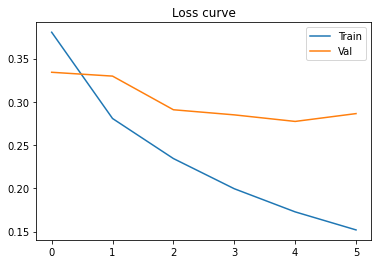

In [108]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = 6
plt.title("Accuracy curve")
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['Train','Val'])
plt.show()
plt.title("Loss curve")
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Train','Val'])
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images. 

#  Check Predictions


In [51]:
class_names = np.array(dataset_info.features['label'].names)

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

### Create an Image Batch and Make Predictions


In [55]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

['sunflowers' 'daisy' 'roses' 'dandelion' 'daisy' 'tulips' 'roses' 'daisy'
 'dandelion' 'sunflowers' 'dandelion' 'tulips' 'tulips' 'tulips'
 'dandelion' 'tulips' 'sunflowers' 'roses' 'roses' 'daisy' 'roses'
 'sunflowers' 'sunflowers' 'sunflowers' 'tulips' 'dandelion' 'roses'
 'daisy' 'tulips' 'dandelion' 'sunflowers' 'roses']


###Print True Labels and Predicted Indices


In [56]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [3 1 4 0 1 2 4 1 0 3 0 2 2 2 0 2 3 4 4 1 4 3 3 3 2 0 4 1 2 0 3 4]
Predicted labels:  [3 1 4 0 1 2 4 1 0 3 0 2 2 2 0 2 3 4 4 1 4 3 3 3 2 0 4 1 2 0 3 4]


# Plot Model Predictions

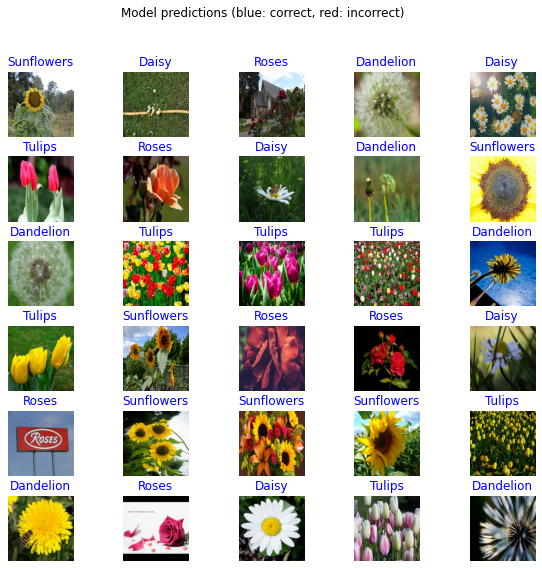

In [57]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")